
# AI-Based Network Intrusion Detection & Attack Classification
## CNN & LSTM (Multi-Class) – UNSW-NB15

- Multi-class attack category prediction
- Early Stopping


## 1. Install & Import Libraries

In [4]:

!pip install numpy pandas scikit-learn tensorflow matplotlib seaborn


In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


## 2. Load Dataset

In [6]:

TRAIN_PATH = r"data/UNSW_NB15_testing-set(in).csv"
TEST_PATH  = r"data/UNSW_NB15_training-set(in).csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

train_df.head()


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


## 3. Exploratory Data Analysis & Data Representation


### 3.1 Attack Category Distribution

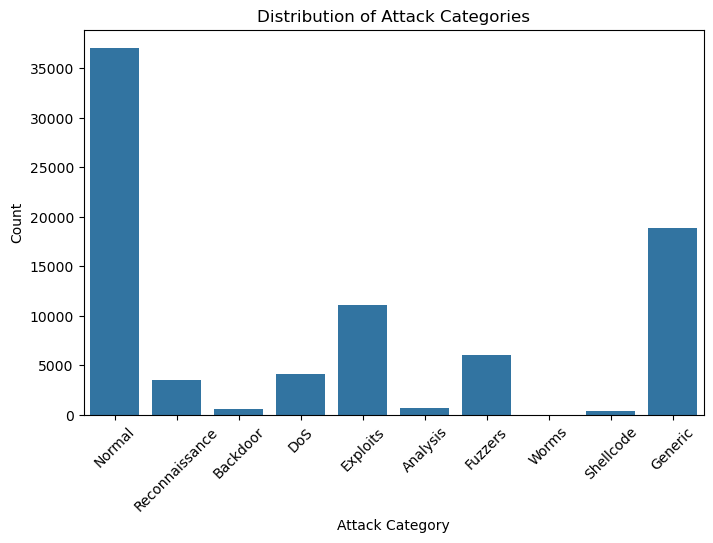

In [17]:

plt.figure(figsize=(8,5))
sns.countplot(x=train_df['attack_cat'])
plt.xticks(rotation=45)
plt.title("Distribution of Attack Categories")
plt.xlabel("Attack Category")
plt.ylabel("Count")
plt.show()


### 3.3 Feature Correlation Heatmap

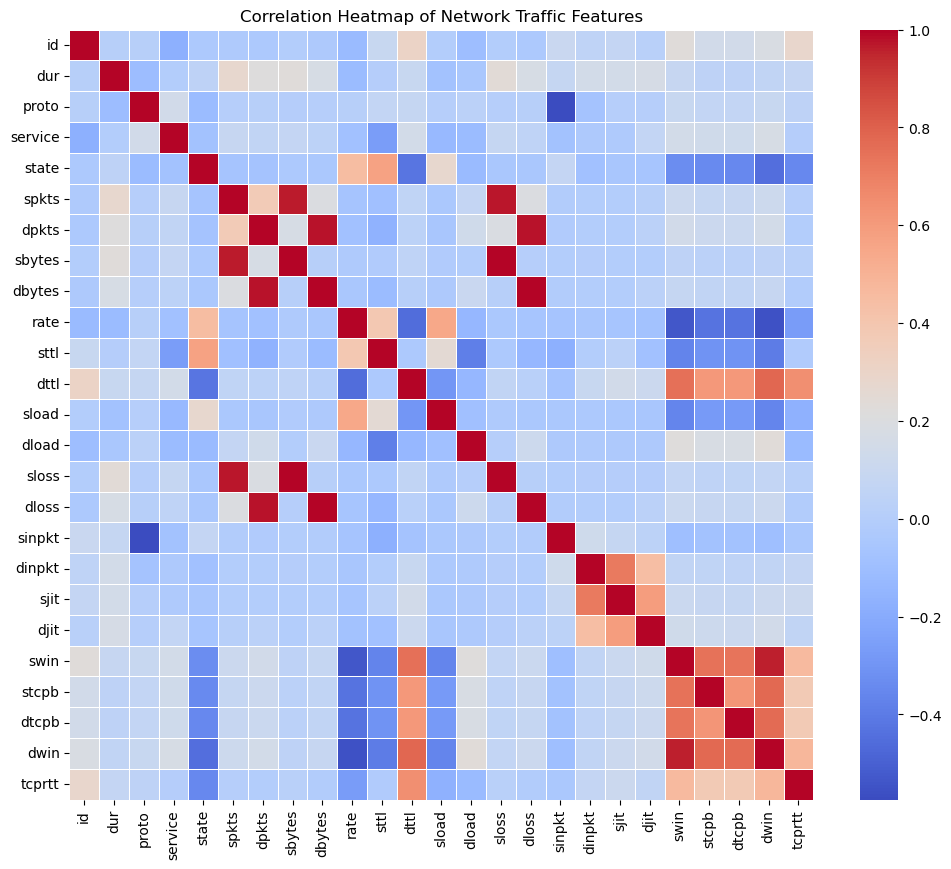

In [18]:

numeric_df = train_df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.iloc[:, :25].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.4)
plt.title("Correlation Heatmap of Network Traffic Features")
plt.show()


### 3.4 Feature Behavior vs Attack Type

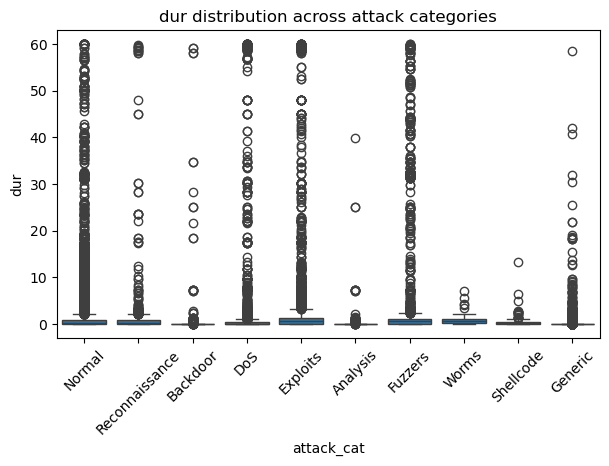

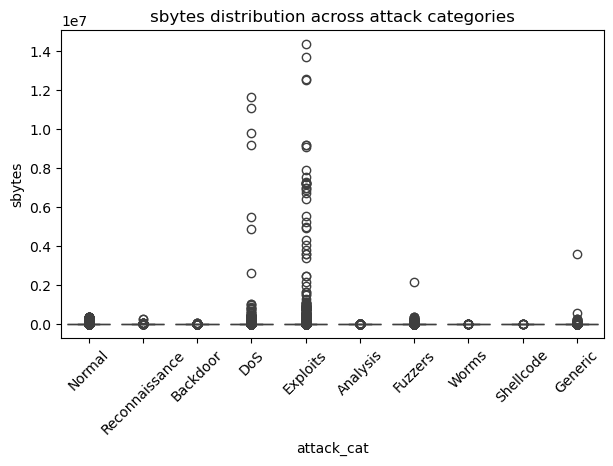

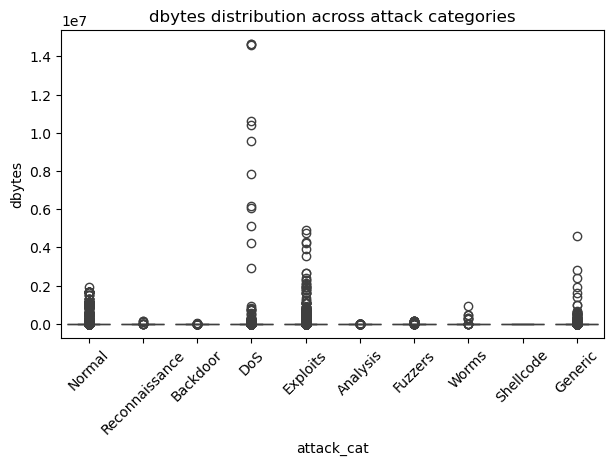

In [19]:

features_to_plot = ['dur', 'sbytes', 'dbytes']

for feature in features_to_plot:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=train_df['attack_cat'], y=train_df[feature])
    plt.xticks(rotation=45)
    plt.title(f"{feature} distribution across attack categories")
    plt.show()


## 4. Encode Categorical Features

In [7]:

categorical_cols = train_df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop('attack_cat')

encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]])
    le.fit(combined)

    train_df[col] = le.transform(train_df[col])
    test_df[col]  = le.transform(test_df[col])

    encoders[col] = le


## 5. Encode Attack Categories

In [8]:

attack_encoder = LabelEncoder()

y_train = attack_encoder.fit_transform(train_df['attack_cat'])
y_test  = attack_encoder.transform(test_df['attack_cat'])

num_classes = len(attack_encoder.classes_)

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)


## 6. Feature Scaling

In [9]:

X_train = train_df.drop(columns=['label', 'attack_cat'])
X_test  = test_df.drop(columns=['label', 'attack_cat'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train_np = np.asarray(X_train)
X_test_np  = np.asarray(X_test)


## 7. Handle Class Imbalance

In [10]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight = dict(enumerate(class_weights))
class_weight


{0: np.float64(12.161299852289513),
 1: np.float64(14.1221269296741),
 2: np.float64(2.013499633162142),
 3: np.float64(0.739597556593604),
 4: np.float64(1.3581656219069613),
 5: np.float64(0.4362884849769488),
 6: np.float64(0.22251891891891892),
 7: np.float64(2.3550343249427916),
 8: np.float64(21.78095238095238),
 9: np.float64(187.11818181818182)}

## 8. CNN Model (Multi-Class)

In [11]:

X_train_cnn = X_train_np.reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_cnn  = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model.fit(
    X_train_cnn,
    y_train_cat,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop]
)


Epoch 1/50


E:\ProgramFiles\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6475 - loss: 2.0750 - val_accuracy: 0.0771 - val_loss: 4.1505
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6996 - loss: 1.6704 - val_accuracy: 0.1405 - val_loss: 3.2528
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7114 - loss: 1.5688 - val_accuracy: 0.1967 - val_loss: 3.3271
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7123 - loss: 1.5342 - val_accuracy: 0.1754 - val_loss: 3.1129
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7153 - loss: 1.4874 - val_accuracy: 0.1870 - val_loss: 2.9681
Epoch 6/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7184 - loss: 1.4569 - val_accuracy: 0.1436 - val_loss: 3.0414
Epoch 7/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7227 - loss: 1.4030 - val_accuracy: 0.1508 - val_loss: 2.8104
Epoch 8/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7265 - loss: 1.4052 - val_accuracy: 0.1599 - va

In [12]:

cnn_pred = cnn_model.predict(X_test_cnn).argmax(axis=1)
print(classification_report(y_test, cnn_pred, target_names=attack_encoder.classes_))


5480/5480 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
                precision    recall  f1-score   support

      Analysis       0.05      0.29      0.09      2000
      Backdoor       0.05      0.26      0.09      1746
           DoS       0.30      0.21      0.24     12264
      Exploits       0.86      0.40      0.55     33393
       Fuzzers       0.58      0.63      0.61     18184
       Generic       1.00      0.98      0.99     40000
        Normal       0.94      0.86      0.90     56000
Reconnaissance       0.49      0.27      0.35     10491
     Shellcode       0.09      0.71      0.16      1133
         Worms       0.02      0.82      0.03       130

      accuracy                           0.68    175341
     macro avg       0.44      0.54      0.40    175341
  weighted avg       0.80      0.68      0.72    175341



## 9. LSTM Model (Multi-Class)

In [22]:

X_train_lstm = X_train_np.reshape(X_train_np.shape[0], 1, X_train_np.shape[1])
X_test_lstm  = X_test_np.reshape(X_test_np.shape[0], 1, X_test_np.shape[1])

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train_np.shape[1])),
    Dropout(0.3),
    LSTM(128),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.fit(
    X_train_lstm,
    y_train_cat,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop]
)


Epoch 1/50


E:\ProgramFiles\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6158 - loss: 1.8958 - val_accuracy: 0.0395 - val_loss: 4.2947
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7162 - loss: 1.4677 - val_accuracy: 0.0662 - val_loss: 3.8323
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7307 - loss: 1.3927 - val_accuracy: 0.1228 - val_loss: 3.4474
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7385 - loss: 1.3480 - val_accuracy: 0.1189 - val_loss: 3.4177
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7444 - loss: 1.3034 - val_accuracy: 0.1658 - val_loss: 3.3133


In [21]:

lstm_pred = lstm_model.predict(X_test_lstm).argmax(axis=1)
print(classification_report(y_test, lstm_pred, target_names=attack_encoder.classes_))


5480/5480 ━━━━━━━━━━━━━━━━━━━━ 5s 951us/step
                precision    recall  f1-score   support

      Analysis       0.05      0.21      0.08      2000
      Backdoor       0.04      0.45      0.08      1746
           DoS       0.16      0.01      0.01     12264
      Exploits       0.78      0.37      0.50     33393
       Fuzzers       0.43      0.65      0.52     18184
       Generic       0.94      0.98      0.96     40000
        Normal       0.98      0.75      0.85     56000
Reconnaissance       0.27      0.10      0.15     10491
     Shellcode       0.06      0.39      0.11      1133
         Worms       0.01      0.85      0.02       130

      accuracy                           0.62    175341
     macro avg       0.37      0.48      0.33    175341
  weighted avg       0.75      0.62      0.65    175341



## 10. Saving Models

In [23]:
cnn_model.save("cnnmulti.keras")


In [24]:
lstm_model.save("lstm_multi.keras")
